# Initialization

In [1]:
# Standard includes
%matplotlib inline
import pickle
from typing import Union

import boost_histogram as bh
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Style setup
import seaborn as sns

sns.set_palette("muted")
sns.set_color_codes()
sns.set_style("ticks")
sns.set_style({"xtick.direction": "in", "ytick.direction": "in"})
sns.set_style({"axes.grid": "True", "grid.color": "0.95"})

plt.rcParams["figure.figsize"] = [6, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["axes.formatter.min_exponent"] = 0

/data/lhcb/users/mackay/miniconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
import mplhep as hep

hep.set_style("LHCb2")

plt.rcParams["font.size"] = 28
plt.rcParams["figure.dpi"] = 50  # Comment out/set to 300 for production plots
plt.rcParams["axes.formatter.min_exponent"] = 0

/tmp/ipykernel_2309812/3971860866.py:3: FutureWarning: ``set_style`` is deprecated: Naming convention is changing to match mpl. Use ``mplhep.style.use()``.
  hep.set_style("LHCb2")


# Setup

In [4]:
def binomial_uncertainty(
    num_pass: Union[float, np.ndarray],
    num_total: Union[float, np.ndarray],
    err_pass_sq: Union[float, np.ndarray] = None,
    err_tot_sq: Union[float, np.ndarray] = None,
) -> float:
    """Return the uncertainty of binomial experiments.

    The parameters can be either floats or numpy arrays.

    The uncertainty is calculated the way ROOT does it in TH1::Divide() when
    binomial errors are specified. This approach has known problems when
    num_pass == num_total or 0. We use this approach to ensure compatibility
    with the original PIDCalib, and because these edge-cases are unlikely to
    occur.

    Args:
        num_pass: Number of passing events.
        num_total: Total number of events.
        err_pass_sq: Squared uncertainty on the number of passing events (sum
            of squares of the event weights). Can be ommited for unweighted events.
        err_tot_sq: Squared uncertainty on the number of total events (sum of
            squares of the event weights). Can be ommited for unweighted events.
    """
    if err_pass_sq is None:
        err_pass_sq = num_pass
    if err_tot_sq is None:
        err_tot_sq = num_total
    prob = num_pass / num_total
    prob_sq = prob ** 2  # type: ignore
    num_total_sq = num_total ** 2  # type: ignore
    return np.sqrt(  # type: ignore
        abs(((1 - 2 * prob) * err_pass_sq + err_tot_sq * prob_sq) / num_total_sq)
    )

# Data

In [40]:
def PlotID_vs_MisID(particles, cuts):
    """
    Function to plot the ID vs. MisID efficiency for
    two particles as a function of momentum.
    
    Args:
        particles: Names of the particles to plot the efficiencies of.
        cuts: Which PID cuts to plot the efficiencies for.            
    """
    
    hists = {}
    for particle in particles:
        for cut in cuts:
            with open(
                f"example_hists/effhists-2023-down-{particle}-{cut}-P.pkl", "rb"
            ) as f:
                hists[f"eff_{particle}_{cut}"] = pickle.load(f)
                hists[f"passing_{particle}_{cut}"] = pickle.load(f)
                hists[f"total_{particle}_{cut}"] = pickle.load(f)
    
    
    colors = {
        "eff_K_DLLK>0": "xkcd:light salmon",
        "eff_K_DLLK>5": "xkcd:red",
        "eff_Pi_DLLK>0": "xkcd:pastel blue",
        "eff_Pi_DLLK>5": "xkcd:blue",
        
        "eff_P_DLLp>5": "xkcd:light salmon",
        "eff_P_DLLp>15": "xkcd:red",
        "eff_Pi_DLLp>5": "xkcd:pastel blue",
        "eff_Pi_DLLp>15": "xkcd:blue",
        
        "eff_P_(DLLp-DLLK)>5": "xkcd:light salmon",
        "eff_P_(DLLp-DLLK)>15": "xkcd:red",
        "eff_K_(DLLp-DLLK)>5": "xkcd:pastel blue",
        "eff_K_(DLLp-DLLK)>15": "xkcd:blue",
    }
    
    for name, hist in hists.items():
        if "eff_" not in name:
            continue
    
        plt.hist(
            hist.axes[0].edges[:-1],
            bins=hist.axes[0].edges,
            weights=hist.values(),
            histtype="stepfilled",
            label=name.replace("eff_", "").replace("_", " ").replace("pi", r"$\pi$"),
            color=colors[name],
            edgecolor=colors[name],
            linewidth=1.5,
            fc=(*mpl.colors.to_rgb(colors[name]), 0.03),
        )
    
        # Comment the errorbar to remove error bars
        plt.errorbar(
            hist.axes[0].centers,
            hist.values(),
            yerr=binomial_uncertainty(
                hists[name.replace("eff_", "passing_")].values(),
                hists[name.replace("eff_", "total_")].values(),
            ),        
            fmt="none",
            color=colors[name],
            capsize=0,
            linewidth=1.5,
            drawstyle="steps-mid",
        )
        
        plt.ylim(top=1.1, bottom=-0.02)
        plt.margins(x=-0.01)
        plt.legend(loc='center right')
        plt.xlabel("Momentum [MeV/c]")
        plt.ylabel("Efficiency")

        plt.figtext(0.3, 0.6, "LHCb\nCollision23 Data")
    
    
    return
    

# K vs. Pi

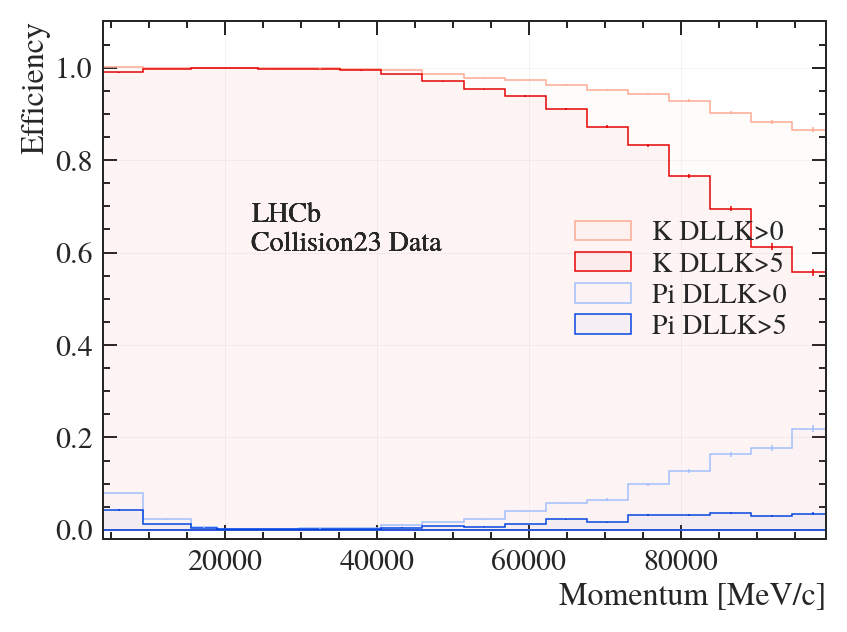

In [41]:
PlotID_vs_MisID(["K", "Pi"], ["DLLK>0", "DLLK>5"])

# P vs. Pi

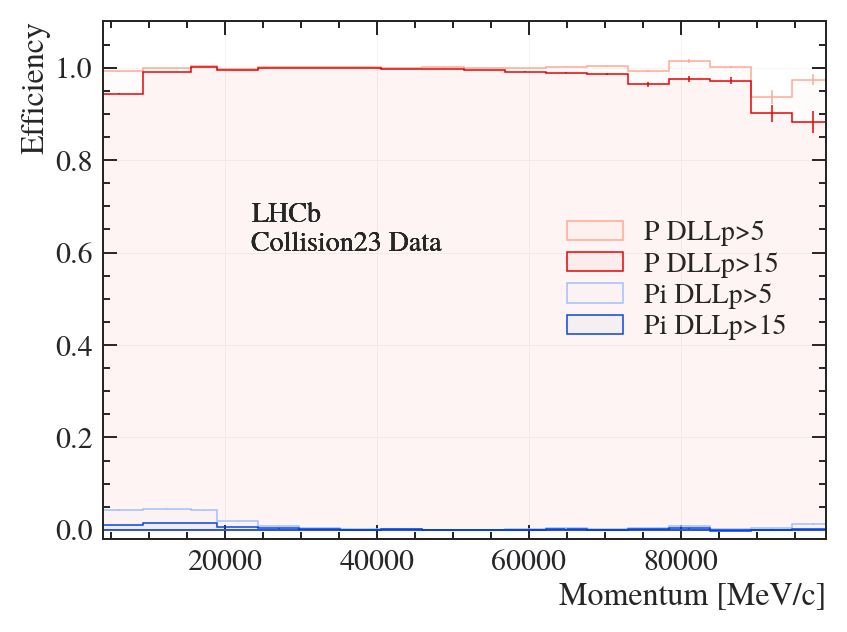

In [42]:
PlotID_vs_MisID(["P", "Pi"], ["DLLp>5", "DLLp>15"])

# P vs K

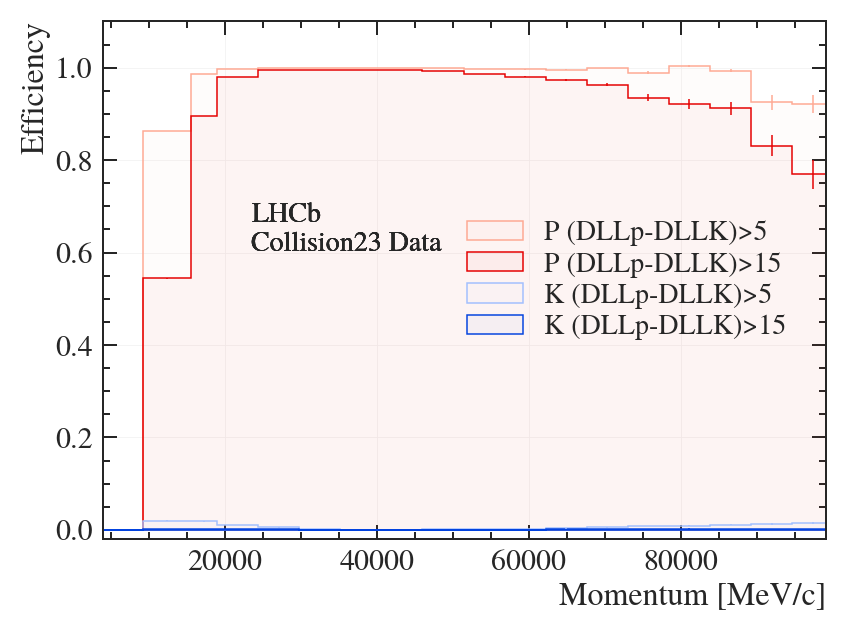

In [43]:
PlotID_vs_MisID(["P", "K"], ["(DLLp-DLLK)>5", "(DLLp-DLLK)>15"])